# Usage consistensy analysis
 Goal: 
 Identify patterns of consistent gym use and seasonal trends, such as “New Year’s resolution” drop-offs, which can inform retention strategies.
	• Tasks:
		○ Analyze check-in data over time to detect frequency trends by month, segmented by age and gender.
		○ Use frequent itemset mining (A-Priori Algorithm) to reveal common patterns in check-in behaviors, like peak times or recurring visits on specific days.
		○ Identify which demographics show high retention versus early drop-off after certain times of the year.
	• Course Topic Covered: Frequent Itemsets - week 5

### 1. Analyzing Check-In Data Over Time (Trends by Month, Age, and Gender)

#### 1.1 Load and explore data 

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt

# Load data
checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])
user_data = pd.read_csv("../data/_raw/users_data.csv")

# Merge user data and checkin data and drop irrelevant columns 
data = user_data.merge(checkin_data, on="user_id", how="left")
data = data.drop(columns= ["first_name", "last_name","birthdate", "calories_burned"])

# Extract month from checkin time 
data['month'] = data['checkin_time'].dt.month 

bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-25', '26-35', '36-50', '51-65', '65+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Group data by month, gender, and age group
monthly_trends = data.groupby(['month', 'gender', 'age_group']).size().reset_index(name='check_in_count')





#### 1.2 Visualize data

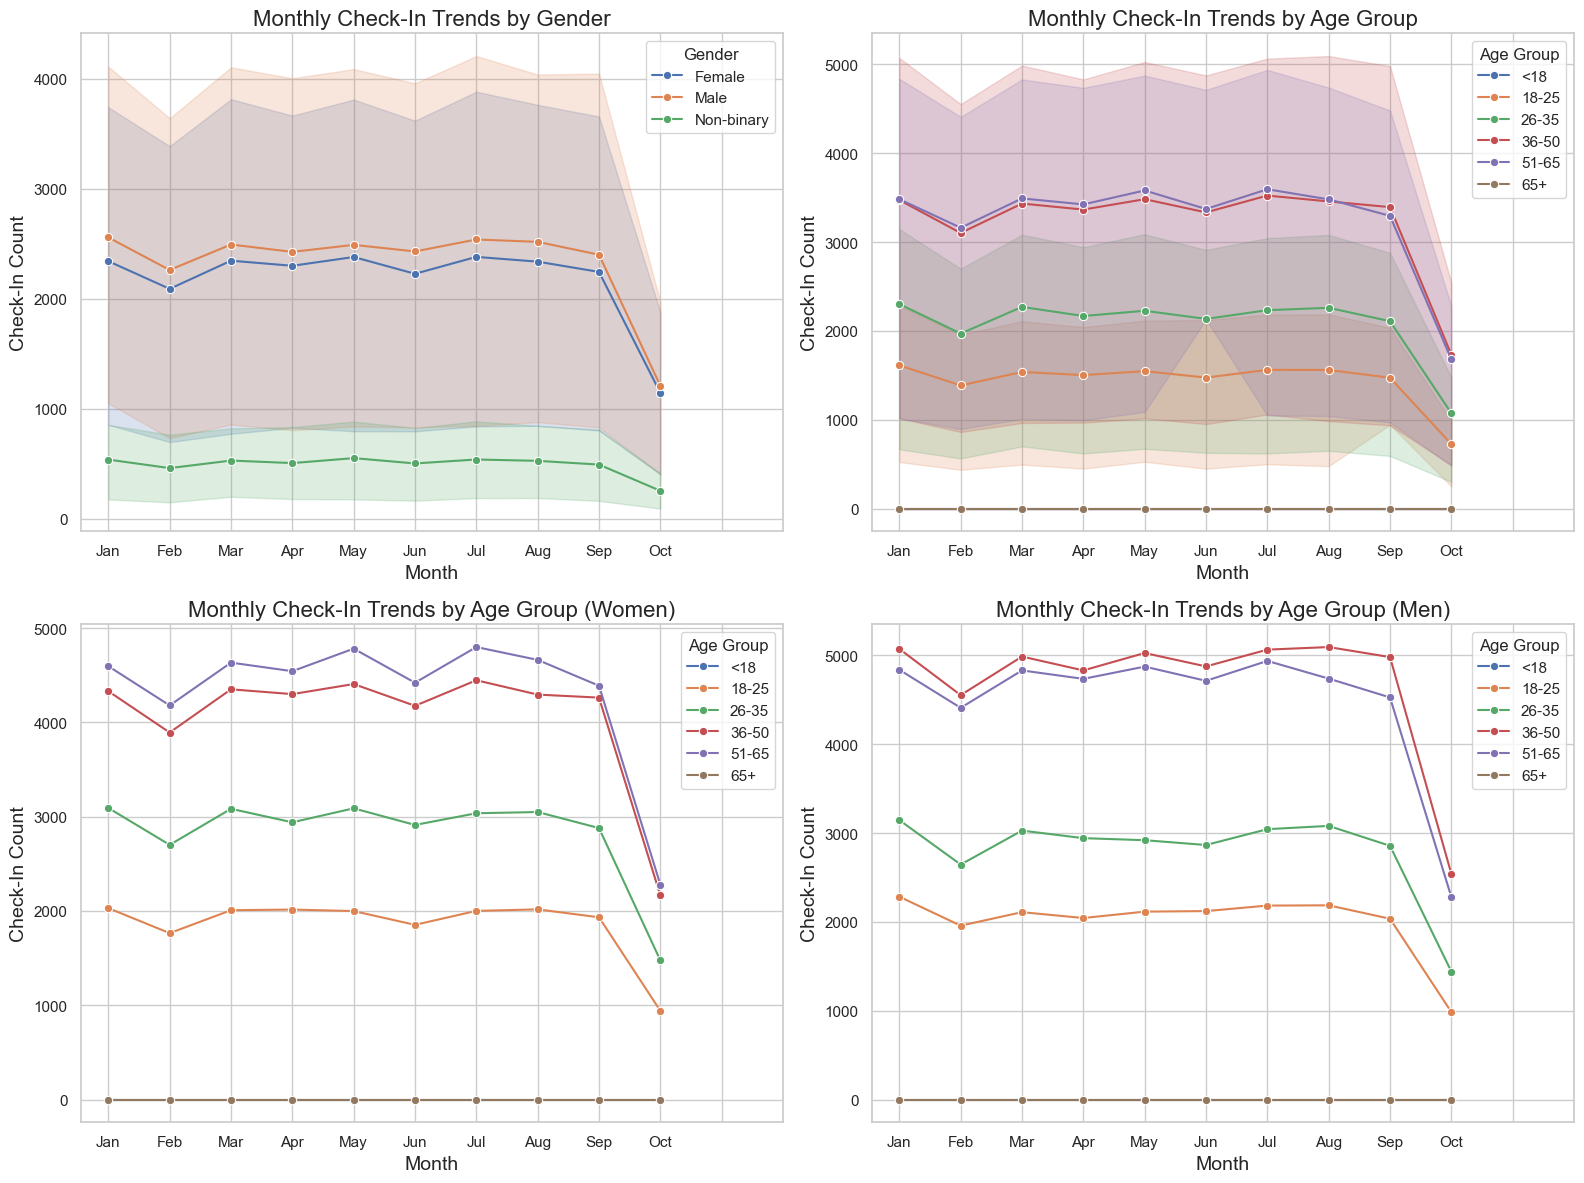

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for the plots
sns.set(style="whitegrid")

# Create a figure with 2 rows and 2 columns (4 subplots in total)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Monthly Check-In Trends by Gender
sns.lineplot(data=monthly_trends, x='month', y='check_in_count', hue='gender', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Check-In Trends by Gender', fontsize=16)
axes[0, 0].set_xlabel('Month', fontsize=14)
axes[0, 0].set_ylabel('Check-In Count', fontsize=14)
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[0, 0].legend(title='Gender')

# Plot 2: Monthly Check-In Trends by Age Group
sns.lineplot(data=monthly_trends, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Monthly Check-In Trends by Age Group', fontsize=16)
axes[0, 1].set_xlabel('Month', fontsize=14)
axes[0, 1].set_ylabel('Check-In Count', fontsize=14)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[0, 1].legend(title='Age Group')

# Plot 3: Monthly Check-in data for women by Age group
women_data = monthly_trends[monthly_trends['gender'] == 'Female']
sns.lineplot(data=women_data, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Monthly Check-In Trends by Age Group (Women)', fontsize=16)
axes[1, 0].set_xlabel('Month', fontsize=14)
axes[1, 0].set_ylabel('Check-In Count', fontsize=14)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[1, 0].legend(title='Age Group')

# Plot 4: Monthly Check-in data for men by Age group
men_data = monthly_trends[monthly_trends['gender'] == 'Male']
sns.lineplot(data=men_data, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Check-In Trends by Age Group (Men)', fontsize=16)
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Check-In Count', fontsize=14)
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[1, 1].legend(title='Age Group')


plt.tight_layout()
plt.show()
